In [1]:
import numpy       as np
import matplotlib.pyplot as plt
import numpy       as np
import matplotlib as mpl
import pandas as pd
import glob 
import os
from scipy.optimize import minimize
from scipy.optimize import fmin
from scipy.optimize import fmin_cobyla
from Weigfun import Weigfun

In [2]:
path = os.getcwd()
home_path = os.path.dirname(path)
gis_folder = f'{home_path}\\GIS'
files = glob.glob(f"{gis_folder}\\*.txt")
files

['C:\\Users\\anne-\\OneDrive - Delft University of Technology\\Documenten\\Environmental Engineering MSc\\ENVM1502-Catchment-model\\GIS\\ascii dem.txt',
 'C:\\Users\\anne-\\OneDrive - Delft University of Technology\\Documenten\\Environmental Engineering MSc\\ENVM1502-Catchment-model\\GIS\\ascii hand.txt',
 'C:\\Users\\anne-\\OneDrive - Delft University of Technology\\Documenten\\Environmental Engineering MSc\\ENVM1502-Catchment-model\\GIS\\ascii husdon basin.txt',
 'C:\\Users\\anne-\\OneDrive - Delft University of Technology\\Documenten\\Environmental Engineering MSc\\ENVM1502-Catchment-model\\GIS\\ascii slope.txt']

In [3]:
# load files created in qgis
DEM=np.genfromtxt(files[0],  dtype=float, autostrip=True)
slope=np.genfromtxt(files[3],  dtype=float, autostrip=True)
hand=np.genfromtxt(files[1],  dtype=float, autostrip=True)
basin = np.where(DEM >=0, 1, 0) #points inside basin 1, outside 0

In [4]:
path = os.getcwd()
home_path = os.path.dirname(path)
data_folder = f'{home_path}\\Data'
files = glob.glob(f"{data_folder}\\*.parquet")
files


['C:\\Users\\anne-\\OneDrive - Delft University of Technology\\Documenten\\Environmental Engineering MSc\\ENVM1502-Catchment-model\\Data\\combined_data.parquet']

In [5]:
#read T, P, Pev, Q data
data = pd.read_parquet(files[0]).dropna()

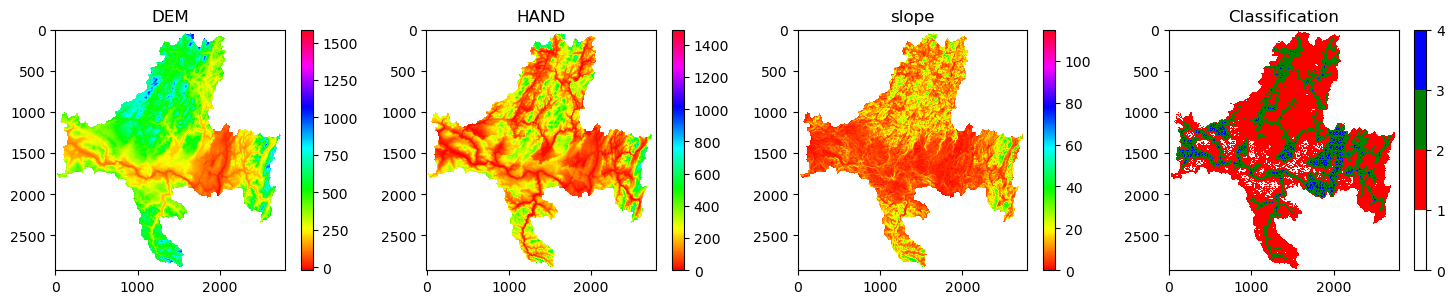

In [6]:
fig, ax = plt.subplots(1, 4, figsize=(15,3))
fig.tight_layout()


# plot DEM
ax[0].set_title("DEM")
DEM[DEM==-9999]=np.nan # deal with nan values
img0 = ax[0].imshow(DEM, cmap='hsv') # plot
plt.colorbar(img0, ax=ax[0])

#plot HAND
ax[1].set_title("HAND")
hand[hand==-9999]=np.nan
img1 = ax[1].imshow(hand, cmap="hsv") # plot
plt.colorbar(img1, ax=ax[1])

#plot slope
ax[2].set_title("slope")
slope[slope==-9999]=np.nan
img2 = ax[2].imshow(slope, cmap="hsv") # plot
plt.colorbar(img2, ax=ax[2])

threshold_h = 100
threshold_s = 18

#make landscape classification
hillslope = (np.array(slope)  >  threshold_s) & (np.array(hand)  >  threshold_h)
plateau   = (np.array(hand)  >  threshold_h)   & (np.array(slope)  <  threshold_s) 
wetland   = np.array(hand)   <= threshold_h
basin     = np.array(basin)  >  0

#calculate percentages
hillslope_per = float(np.sum(hillslope)) /np.sum(basin) 
wetland_per   = float(np.sum(wetland))   /np.sum(basin)
plateau_per   = float(np.sum(plateau))   /np.sum(basin)
 

#matrics with landscape classes
landscapes            = np.zeros(DEM.shape)
landscapes[plateau]   = 1
landscapes[hillslope] = 2
landscapes[wetland]   = 3

#plot landscapes
ax[3].set_title("Classification")
cmap = mpl.colors.ListedColormap(['white', 'red', 'green', 'blue'])
bounds=[0,1,2,3,4]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
img3 = ax[3].imshow(landscapes, cmap=cmap, norm=norm)
plt.colorbar(img3,ax=ax[3])

In [7]:
#Divide landscape areas in different height categories
A_lst = []
for i in range(1,4):
    
    A1 = len(DEM[(landscapes==i) & (DEM<=250)]) / len(DEM[(landscapes==i)])
    A2 = len(DEM[(landscapes==i) & (DEM>250) & (DEM <=500)]) / len(DEM[(landscapes==i)])
    A3 = len(DEM[(landscapes==i) & (DEM>500) & (DEM <=750)]) / len(DEM[(landscapes==i)])
    A4 = len(DEM[(landscapes==i) & (DEM>750)]) / len(DEM[(landscapes==i)])

    
    A_lst.append([A1, A2, A3, A4])

heights = [125, 375, 625, 875] # m


In [8]:
def fobj(p, slope, hand, basin):
    threshold_h, threshold_s = p
    
    hillslope = (np.array(slope)  >  threshold_s) & (np.array(hand)  >  threshold_h)
    plateau   = (np.array(hand)  >  threshold_h)   & (np.array(slope)  <  threshold_s) 
    wetland   = np.array(hand)   <= threshold_h
    basin     = np.array(basin)  >  0
    
    hillslope_per = float(np.sum(hillslope)) /np.sum(basin) 
    wetland_per   = float(np.sum(wetland))   /np.sum(basin)
    plateau_per   = float(np.sum(plateau))   /np.sum(basin)
    
    sum_landscape = np.sum([hillslope_per, wetland_per, plateau_per])
    
    sse = sum_landscape - 1
    return sse


def constr1(p, slope, hand, basin):
    return p[0]

def constr2(p, slope, hand, basin):
    return p[1]

popt = fmin_cobyla(fobj, [100,20], cons=[constr1, constr2], args=(slope, hand, basin),  rhoend=1e-7)

h_opt, s_opt = popt
print('Value for hand threshold', h_opt)
print('Value for slope threshold:', s_opt)

Value for hand threshold 86.84972644426556
Value for slope threshold: 19.473731744011083


In [15]:
def FLEXtopo(ParPlateau, ParHillslope, ParWetland, ParCatchment,forcing, landscapes, snow=True):

    #parameters and constants
    Tlag=ParCatchment[1]
    Ks=ParCatchment[0]
    dt=1
    tmax=len(forcing['P'].values)

    #initialize states
    States_plateau=np.zeros((tmax,4))
    States_hillslope=np.zeros((tmax,4))
    States_wetland=np.zeros((tmax,4))
    Ss=np.zeros((tmax,1))

    #initialize fluxes
    Fluxes_plateau=np.zeros((tmax,4))
    Fluxes_hillslope=np.zeros((tmax,4))
    Fluxes_wetland=np.zeros((tmax,3))
    Qsdt=np.zeros(tmax)
    Qtotdt=np.zeros(tmax)
    
    #initialize inbetween snow storages
    Snow_A_plateau=np.zeros((tmax,4))
    Snow_A_hillslope=np.zeros((tmax,4))
    Snow_A_wetland=np.zeros((tmax,4))
    #
    #loop over time
    for t in range(0,tmax):
        
        #plateau
        Fluxes_plateau, States_plateau = plateau(t, ParPlateau, forcing, Fluxes_plateau, States_plateau, Snow_A_plateau, A_lst[0], snow=snow)
        #hillslope
        Fluxes_hillslope, States_hillslope = hillslope(t, ParHillslope, forcing, Fluxes_hillslope, States_hillslope, Snow_A_hillslope, A_lst[1], snow=snow)

        #wetland
        Fluxes_wetland, States_wetland, Ss = wetland(t, ParWetland, forcing, Fluxes_wetland, States_wetland, Ss, landscapes[2], Snow_A_wetland, A_lst[2], snow=snow)

        # Slow Reservoir
        Ss[t] = Ss[t] + Fluxes_plateau[t,3] * landscapes[0] + Fluxes_hillslope[t,3] * landscapes[1] 
        Qsdt = dt*Ks*Ss[t] 
        Ss[t] = Ss[t]-min(Qsdt,Ss[t])
        if t < tmax-1:
            Ss[t+1] = Ss[t]

        Qtotdt[t] = Qsdt + Fluxes_plateau[t,2] * landscapes[0] + Fluxes_hillslope[t,2] * landscapes[1] +   Fluxes_wetland[t, 2] * landscapes[2]  


    # Offset Q

    Weigths=Weigfun(Tlag)
    
    Qm = np.convolve(Qtotdt,Weigths)
    Qm = Qm[0:tmax]
    
    return(Qm)

In [16]:
def hillslope(timestep, Par, forcing, Fluxes, States, Ssnow_A, A_lst, snow):
    #HBVpareto Calculates values of 3 objective functions for HBV model

    Imax=Par[0]
    Ce=Par[1]
    Sumax=Par[2]
    beta=Par[3]
    D=Par[4]
    Kf=Par[5]
    
    Prec = forcing['P'].values
    Qo = forcing['Q'].values
    Etp = forcing['Pev'].values
    temp = forcing['T'].values
    Psnow = np.zeros(len(Prec))


    tmax=len(Prec)
    
    Si    = States[:,0]
    Su    = States[:,1]
    Sf    = States[:,2]
    Ssnow = States[:,3]

    Eidt  = Fluxes[:,0]
    Eadt  = Fluxes[:,1]
    Qfdt  = Fluxes[:,2]
    Qusdt = Fluxes[:,3]

    dt = 1
    t = timestep
    
    Er = 331 #m
    Tt = -0.5 # degc
    FM = 3    # mm/deg/d
    
    Epdt = Etp[t] * dt
    TR   = temp[t] * dt
    Pldt = 0
    
    if snow: 
        for A_index, Ei in enumerate(heights): 
            
            Ti = TR - 0.6 * (Ei-Er) / 100
            
            if Ti < Tt and t != 0:
                Pdt                    = 0                                                     # no rainfall
                Ps                     = Prec[t] * dt                                          # precipitation is snow 
                M                      = 0                                                     # Too cold for melt
                Ssnow_A[t, A_index]    = Ssnow_A[t-1, A_index] + Ps                            # add snow to the prev day
                Pldt_A                 = 0                                                     # no outflow as too cold
            # then must be above
            else:
                Pdt                    = Prec[t] * dt                                          # all precip is rainfall
                Ps                     = 0                                                     # no snow 
                M                      = min(Ssnow_A[t-1, A_index] / dt, FM * (Ti - Tt))       # calculate melt
                Ssnow_A[t, A_index]    = Ssnow_A[t-1, A_index] - M * dt                        # remove melted snow
                Pldt_A                 = Pdt + M                                               # outflow = rain + melt
            
            fi = A_lst[A_index]
            Pldt = Pldt_A * fi
            Ssnow[t] += Ssnow_A[t, A_index] * fi
    
            if t < tmax-1:
                Ssnow[t+1] = Ssnow[t]
            
    else:
        Pdt  = Prec[t] * dt 
        Pldt = 0
        Ps   = 0
      
    
    
    
    
    # Interception Reservoir
    if Pdt>0:
        Si[t]=Si[t]+Pdt
        Pedt=max(0,Si[t]-Imax)
        Si[t]=Si[t]-Pedt
        Eidt[t]=0
    else:
    # Evaporation only when there is no rainfall
        Pedt=0
        Eidt[t]=min(Epdt,Si[t])
        Si[t]=Si[t]-Eidt[t]

    if t<tmax-1:
        Si[t+1]=Si[t]


    # Unsaturated Reservoir
    if Pedt>0:
        rho = (Su[t] / Sumax) ** beta            
        Su[t] = Su[t] + (1-rho) * Pedt
        Qufdt = rho*Pedt
    else:
        Qufdt=0

    # Transpiration
    Epdt=max(0,Epdt-Eidt[t])
    Eadt[t]=Epdt*(Su[t]/(Sumax*Ce))
    Eadt[t]=min(Eadt[t],Su[t])
    Su[t]=Su[t]-Eadt[t]

    # Preferential Percolation
    
    Qusdt = max(0, (Su[t]/Sumax) * D * dt - Sumax)
    Su[t] = Su[t] - Qusdt
    
    if t<tmax-1:
        Su[t+1]=Su[t]
        
    # Fast Reservoir
    Sf[t] = Sf[t] + (1-D) * Qufdt * dt
    Qfdt[t] =  dt*Kf*Sf[t]
    Sf[t]=Sf[t] - min(Qfdt[t],Sf[t])
    
    if t<tmax-1:
        Sf[t+1]=Sf[t]
        
    Psnow[i] = Ps
    
    #save output
    States[:,0] = Si
    States[:,1] = Su
    States[:,2] = Sf
    States[:,3] = Ssnow

    Fluxes[:,0] = Eidt
    Fluxes[:,1] = Eadt
    Fluxes[:,2] = Qfdt
    Fluxes[:,3] = Qusdt 

    return(Fluxes, States)

In [17]:
def plateau(  timestep, Par, forcing, Fluxes, States, Ssnow_A, A_lst, snow):
    #HBVpareto Calculates values of 3 objective functions for HBV model

    Imax=Par[0]
    Ce=Par[1]
    Sumax=Par[2]
    beta=Par[3]
    Pmax=Par[4]
    Kf=Par[5]

    Prec = forcing['P'].values
    Qo = forcing['Q'].values
    Etp = forcing['Pev'].values
    temp = forcing['T'].values
    Psnow = np.zeros(len(Prec))


    tmax=len(Prec)
    Si=States[:,0]
    Su=States[:,1]
    Sf=States[:,2]
    Ssnow = States[:,3]

    Eidt=Fluxes[:,0]
    Eadt=Fluxes[:,1]
    Qfdt=Fluxes[:,2]
    Qusdt=Fluxes[:,3]

    dt=1
    t=timestep
    
    Er = 331 #m
    Tt = -0.5 # degc
    FM = 3    # mm/deg/d
    
    Epdt = Etp[t] * dt
    TR   = temp[t] * dt
    Pldt = 0
    
    if snow: 
        for A_index, Ei in enumerate(heights): 
            
            Ti = TR - 0.6 * (Ei-Er) / 100
            
            if Ti < Tt and t != 0:
                Pdt                    = 0                                                     # no rainfall
                Ps                     = Prec[t] * dt                                          # precipitation is snow 
                M                      = 0                                                     # Too cold for melt
                Ssnow_A[t, A_index]    = Ssnow_A[t-1, A_index] + Ps                            # add snow to the prev day
                Pldt_A                 = 0                                                     # no outflow as too cold
            # then must be above
            else:
                Pdt                    = Prec[t] * dt                                          # all precip is rainfall
                Ps                     = 0                                                     # no snow 
                M                      = min(Ssnow_A[t-1, A_index] / dt, FM * (Ti - Tt))       # calculate melt
                Ssnow_A[t, A_index]    = Ssnow_A[t-1, A_index] - M * dt                        # remove melted snow
                Pldt_A                 = Pdt + M                                               # outflow = rain + melt
            
            fi = A_lst[A_index]
            Pldt = Pldt_A * fi
            Ssnow[t] += Ssnow_A[t, A_index] * fi
    
            if t < tmax-1:
                Ssnow[t+1] = Ssnow[t]
            
    else:
        Pdt  = Prec[t] * dt 
        Pldt = 0
        Ps   = 0

    # Interception Reservoir
    if Pdt>0:
        Si[t]=Si[t]+Pdt
        Pedt=max(0,Si[t]-Imax)
        Si[t]=Si[t]-Pedt
        Eidt[t]=0
    else:
    # Evaporation only when there is no rainfall
        Pedt=0
        Eidt[t]=min(Epdt,Si[t])
        Si[t] = Si[t]-Eidt[t]

    if t<tmax-1:
        Si[t+1]=Si[t]


    # Unsaturated Reservoir
    if Pedt>0:
        rho = (Su[t] / Sumax) ** beta            
        Su[t] = Su[t] + (1-rho) * Pedt
        Qufdt = rho*Pedt
    else:
        Qufdt=0
 
    # Transpiration
    Epdt=max(0,Epdt-Eidt[t])
    Eadt[t]=Epdt*(Su[t]/(Sumax*Ce))
    Eadt[t]=min(Eadt[t],Su[t])
    Su[t]=Su[t]-Eadt[t]

    # Percolation
    Qusdt=(Su[t]/Sumax)*Pmax*dt
    Su[t]=Su[t]-min(Qusdt,Su[t])
    if t<tmax-1:
        Su[t+1]=Su[t]

    # Fast Reservoir
    Sf[t]=Sf[t]+Qufdt
    Qfdt[t]= dt*Kf*Sf[t]
    Sf[t]=Sf[t]-min(Qfdt[t],Sf[t])
    if t<tmax-1:
        Sf[t+1]=Sf[t]
        
        
    Psnow[i] = Ps
    
    #save output
    States[:,0] = Si
    States[:,1] = Su
    States[:,2] = Sf
    States[:,3] = Ssnow

    Fluxes[:,0]=Eidt
    Fluxes[:,1]=Eadt
    Fluxes[:,2]=Qfdt
    Fluxes[:,3]=Qusdt

    return(Fluxes, States)

In [18]:
def wetland(  timestep, Par, forcing, Fluxes, States, Ss, landscape_per, Ssnow_A, A_lst, snow):
    #HBVpareto Calculates values of 3 objective functions for HBV model

    Imax=Par[0]
    Ce=Par[1]
    Sumax=Par[2]
    beta=Par[3]
    Cmax=Par[4]
    Kf=Par[5]

    Prec = forcing['P'].values
    Qo = forcing['Q'].values
    Etp = forcing['Pev'].values
    temp = forcing['T'].values
    Psnow = np.zeros(len(Prec))


    tmax=len(Prec)
    
    Si=States[:,0]
    Su=States[:,1]
    Sf=States[:,2]
    Ssnow = States[:,3]

    Eidt=Fluxes[:,0]
    Eadt=Fluxes[:,1]
    Qfdt=Fluxes[:,2]

    dt=1
    t=timestep
    Er = 331 #m
    Tt = -0.5 # degc
    FM = 3    # mm/deg/d
    
    Epdt = Etp[t] * dt
    TR   = temp[t] * dt
    Pldt = 0
    
    if snow: 
        for A_index, Ei in enumerate(heights): 
            
            Ti = TR - 0.6 * (Ei-Er) / 100
            
            if Ti < Tt and t != 0:
                Pdt                    = 0                                                     # no rainfall
                Ps                     = Prec[t] * dt                                          # precipitation is snow 
                M                      = 0                                                     # Too cold for melt
                Ssnow_A[t, A_index]    = Ssnow_A[t-1, A_index] + Ps                            # add snow to the prev day
                Pldt_A                 = 0                                                     # no outflow as too cold
            # then must be above
            else:
                Pdt                    = Prec[t] * dt                                          # all precip is rainfall
                Ps                     = 0                                                     # no snow 
                M                      = min(Ssnow_A[t-1, A_index] / dt, FM * (Ti - Tt))       # calculate melt
                Ssnow_A[t, A_index]    = Ssnow_A[t-1, A_index] - M * dt                        # remove melted snow
                Pldt_A                 = Pdt + M                                               # outflow = rain + melt
            
            fi = A_lst[A_index]
            Pldt = Pldt_A * fi
            Ssnow[t] += Ssnow_A[t, A_index] * fi
    
            if t < tmax-1:
                Ssnow[t+1] = Ssnow[t]
            
    else:
        Pdt  = Prec[t] * dt 
        Pldt = 0
        Ps   = 0

    
    
    # Interception Reservoir
    if Pdt>0:
        Si[t]=Si[t]+Pdt
        Pedt=max(0,Si[t]-Imax)
        Si[t]=Si[t]-Pedt
        Eidt[t]=0
    else:
    # Evaporation only when there is no rainfall
        Pedt=0
        Eidt[t]=min(Epdt,Si[t])
        Si[t]=Si[t]-Eidt[t]

    if t<tmax-1:
        Si[t+1]=Si[t]

    # Unsaturated Reservoir
    if Pedt>0:
        rho=(Su[t]/Sumax)**beta            
        Su[t]=Su[t]+(1-rho)*Pedt
        Qufdt=rho*Pedt
    else:
        Qufdt=0

    # Transpiration
    Epdt=max(0,Epdt-Eidt[t])
    Eadt[t]=Epdt*(Su[t]/(Sumax*Ce))
    Eadt[t]=min(Eadt[t],Su[t])
    Su[t]=Su[t]-Eadt[t]
    
    #Capillary rise
    Qrdt= (1 - Su[t]/Sumax) * Cmax * dt
    
    #check if the groundwater has enough water (note: you need to use the landscape percentage!!!)
    Qrdt = min(Qrdt, landscape_per * Ss[t])

    # su cannot be more than sumax
    if( (Su[t] + Qrdt) > Sumax):
        Qrdt = Sumax - Su[t]

    Su[t] = Su[t] + Qrdt * landscape_per
    Ss[t] = Ss[t] - Qrdt * landscape_per # * landscape_per

    if t<tmax-1:
        Su[t+1]=Su[t]

    Psnow[i] = Ps
    
    # Fast Reservoir
    Sf[t]=Sf[t]+Qufdt
    Qfdt[t]= dt*Kf*Sf[t]
    Sf[t]=Sf[t]-min(Qfdt[t],Sf[t])
    if t<tmax-1:
        Sf[t+1]=Sf[t]

    #save output
    States[:,0] = Si
    States[:,1] = Su
    States[:,2] = Sf
    States[:,3] = Ssnow

    Fluxes[:,0]=Eidt
    Fluxes[:,1]=Eadt
    Fluxes[:,2]=Qfdt

    return(Fluxes, States, Ss)

Text(0.5, 1.0, 'Runoff Distributed model with NSE of -1.346')

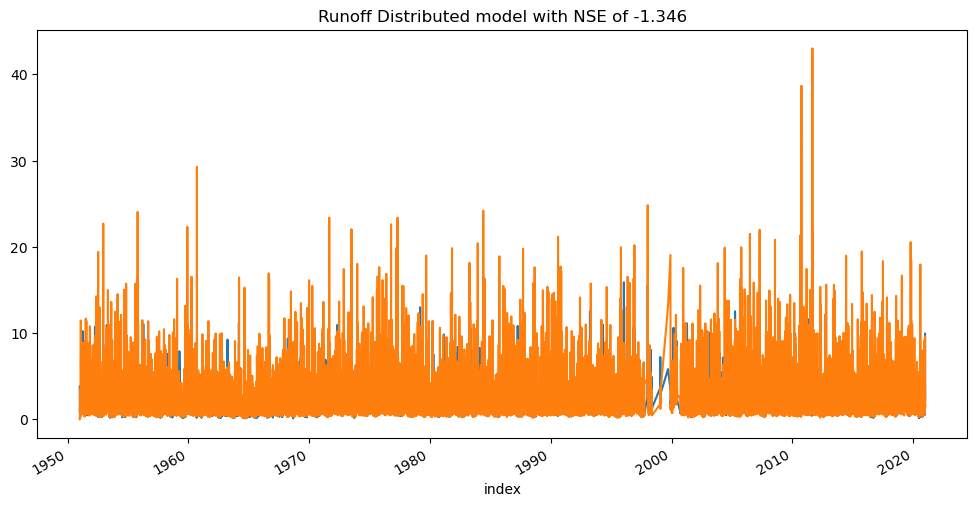

In [27]:
                  #      Imax Ce Sumax beta Pmax    Kf  
ParPlateau   = np.array([3.2, 0.50, 17.40, 0.95, 1.76, 0.91])   
                  #      Imax Ce Sumax beta D     Kf  
ParHillslope = np.array([3.25, 0.50, 321.99, 0.99, 0.4,0.97])
                  #      Imax Ce Sumax beta Cmax     Kf  
ParWetland   = np.array([9.94, 0.50, 53.25, 0.70, 0.65, 0.45])
              # Ks Tlag
ParCatchment = np.array([0.0281, 2.21])

#landscape percentages
landscape_per= np.array([plateau_per, hillslope_per, wetland_per])



Qm = FLEXtopo(ParPlateau, ParHillslope, ParWetland, ParCatchment, data, landscape_per, snow=False)
Qo = data['Q'].values

ind = np.where(Qo>=0)
QoAv = np.mean(Qo[ind])
ErrUp = np.sum((Qo - Qm) ** 2)
ErrDo = np.sum((Qo - QoAv) ** 2)
Obj = 1 - (ErrUp / ErrDo)

Qo = data['Q']
data['Qm'] = Qm

fig, ax = plt.subplots(figsize=(12,6))
Qo.plot(ax=ax, label='Actual')
data.Qm.plot(ax=ax, label='Modelled')
ax.set_title(f'Runoff Distributed model with NSE of {Obj:.3f}')
#plt.show()

In [ ]:
# GLUE
nmax = 200
A = np.zeros((nmax,21))
n_feasible = 0

ParPlateau   = np.array([3.2, 0.50, 17.40, 0.95, 1.76, 0.91])   
                  #      Imax Ce Sumax beta D     Kf  
ParHillslope = np.array([3.25, 0.50, 321.99, 0.99, 0.4,0.97])
                  #      Imax Ce Sumax beta Cmax     Kf  
ParWetland   = np.array([9.94, 0.50, 53.25, 0.70, 0.65, 0.45])
              # Ks Tlag
ParCatchment = np.array([0.0281, 2.21])

ParMinn = np.array([ 0.10,   0.1,  10,    .2,   .1, 0.01,   0.10,  0.1,  10.0,   .2, 0.01,  0.01,   0.1,    .1,    10,  .2,  0.01, 0.01,   0.0001,  .001])
ParMaxn = np.array([10.00,   2.0,  50,   4.0,  4.0, 3.00,  10.00,  2.0, 800.0,  4.0, 4.0,   3.00,  16.0,   2.0,   100, 4.0,  5.00, 4.00,   0.1000,  6])

for n in range(1,nmax): 
    Rnum = np.random.random(20)  #generate a vector of random number
    Par = Rnum * (ParMaxn - ParMinn) + ParMinn # calculate the random parameter set
    
    Qm = FLEXtopo(Par[0:6], Par[6:12], Par[12:18], Par[18:20], data, landscape_per, snow=False)
    Qo = data['Q'].values

    ind = np.where(Qo>=0)
    QoAv = np.mean(Qo[ind])
    ErrUp = np.sum((Qo - Qm) ** 2)
    ErrDo = np.sum((Qo - QoAv) ** 2)
    Obj = 1 - (ErrUp / ErrDo)

    if Obj>0:
        A[n_feasible,0:20]= Par
        A[n_feasible,20] = Obj
        n_feasible = n_feasible + 1
   
    


np.savetxt(f'{data_folder}\\MC2_distributed.txt',A[0:n_feasible,:], delimiter =',')

#find the optimum

Opt_obj = A.argmax(axis=0)[20]


#find the optimal parameter set
OptPar = A[Opt_obj, 0:20]

Text(0.5, 1.0, 'Runoff Distributed model with NSE of 0.281 check 0.281')

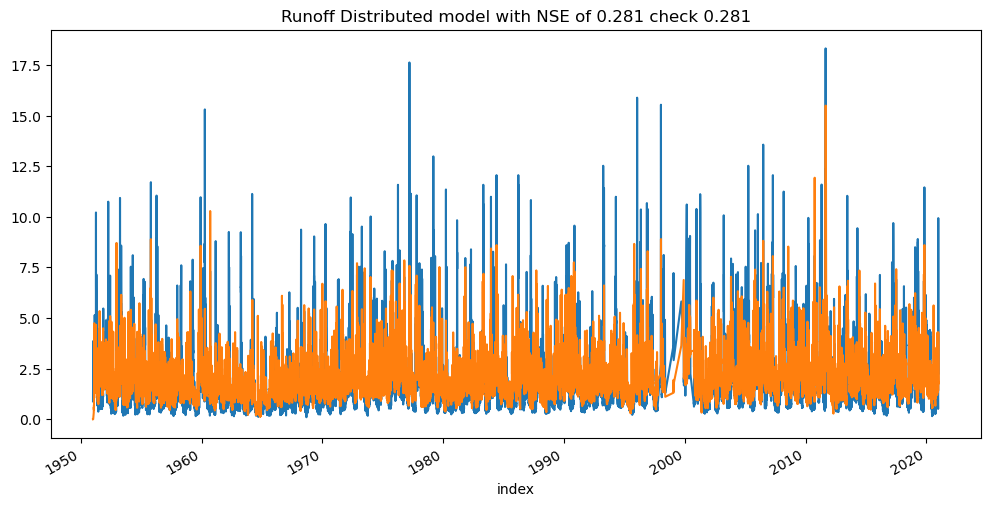

In [77]:
Qm = FLEXtopo(OptPar[0:6], OptPar[6:12], OptPar[12:18], OptPar[18:20], data, landscape_per, snow=False)
Qo = data['Q'].values
ind = np.where(Qo>=0)
QoAv = np.mean(Qo[ind])
ErrUp = np.sum((Qo - Qm) ** 2)
ErrDo = np.sum((Qo - QoAv) ** 2)
Obj = 1 - (ErrUp / ErrDo)

Obj_check = A[Opt_obj, 20]


Qo = data['Q']
data['Qm'] = Qm

fig, ax = plt.subplots(figsize=(12,6))
Qo.plot(ax=ax, label='Actual')
data.Qm.plot(ax=ax, label='Modelled')
ax.set_title(f'Runoff Distributed model with NSE of {Obj:.3f} check {Obj_check:.3f}')

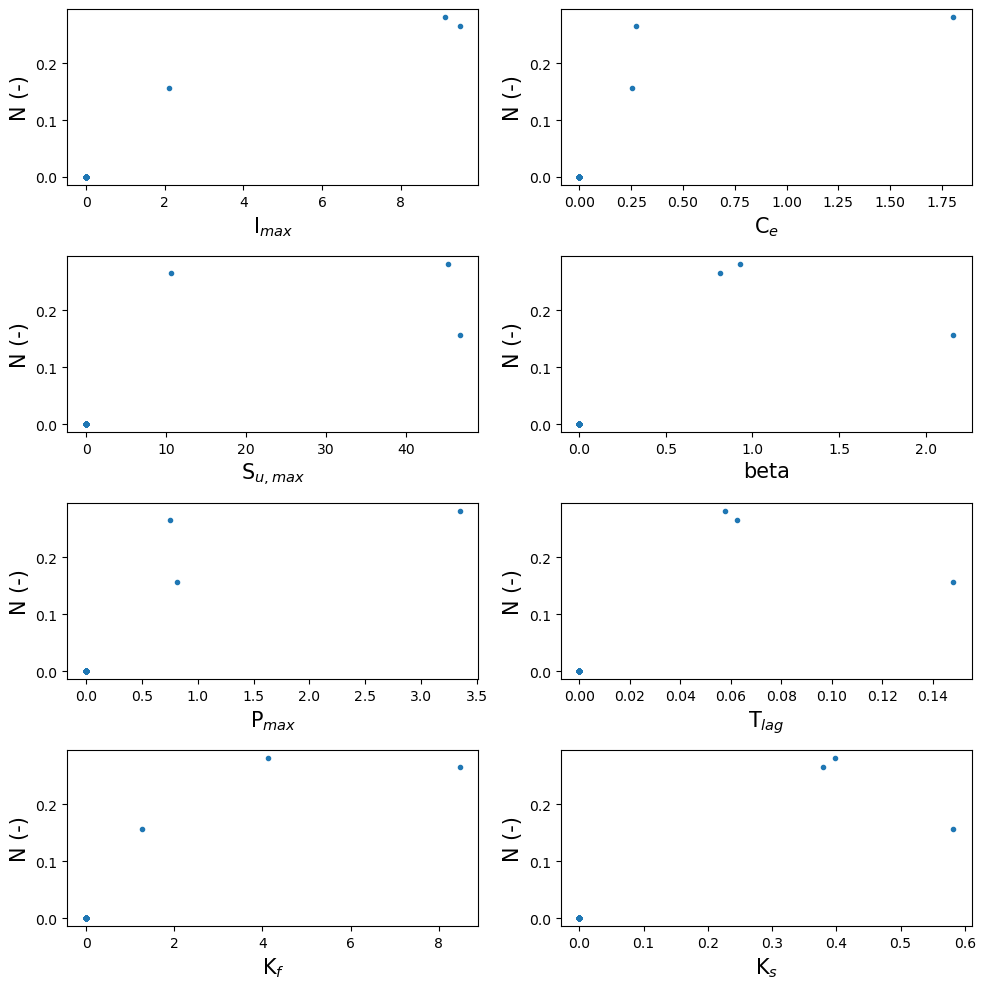

In [46]:
fig, ax = plt.subplots(4,2, figsize=(10,10))


ax[0,0].plot(A[:,0],A[:,20],'.')
ax[0,0].set_xlabel('I$_{max}$', fontsize=15)
ax[0,0].set_ylabel('N (-)', fontsize=15)

plt.subplot(422)
ax[0,1].plot(A[:,1],A[:,20],'.')
ax[0,1].set_xlabel('C$_{e}$', fontsize=15)
ax[0,1].set_ylabel('N (-)', fontsize=15)

plt.subplot(423)
ax[1,0].plot(A[:,2],A[:,20],'.')
ax[1,0].set_xlabel('S$_{u,max}$', fontsize=15)
ax[1,0].set_ylabel('N (-)', fontsize=15), 

plt.subplot(424)
ax[1,1].plot(A[:,3],A[:,20],'.')
ax[1,1].set_xlabel('beta', fontsize=15)
ax[1,1].set_ylabel('N (-)', fontsize=15)

plt.subplot(425)
ax[2,0].plot(A[:,4],A[:,20],'.')
ax[2,0].set_xlabel('P$_{max}$', fontsize=15)
ax[2,0].set_ylabel('N (-)', fontsize=15)

plt.subplot(426)
ax[2,1].plot(A[:,5],A[:,20],'.')
ax[2,1].set_xlabel('T$_{lag}$', fontsize=15)
ax[2,1].set_ylabel('N (-)', fontsize=15)

plt.subplot(427)
ax[3,0].plot(A[:,6],A[:,20],'.')
ax[3,0].set_xlabel('K$_{f}$', fontsize=15)
ax[3,0].set_ylabel('N (-)', fontsize=15)

plt.subplot(428)
ax[3,1].plot(A[:,7],A[:,20],'.')
ax[3,1].set_xlabel('K$_{s}$', fontsize=15)
ax[3,1].set_ylabel('N (-)', fontsize=15)

plt.tight_layout()
plt.show()


In [76]:
#### Calculate objective function
Qm = FLEXtopo(OptPar[0:6], OptPar[6:12], OptPar[12:18], OptPar[18:20], data, landscape_per, snow=False)
Qo = data['Q'].values
Obj_type = 'NSE_log'
# filter any unrealistic values
ind   = np.where(Qm>0)

Qm    = Qm[ind]

if Obj_type == "NSE":
    Qo    = Qo[ind]
    


# in case other obj, use these
elif Obj_type == "NSE_log":
    Qo = np.log(Qo[ind])
    Qm = np.log(Qm)

elif Obj_type == "NSE_sqrt":
    Qo    = np.sqrt(Qo[ind])
    Qm  = np.sqrt(Qm)

# compute final statistic
QoAv  = np.mean(Qo)

ErrUp = np.sum((Qm - Qo)**2)
ErrDo = np.sum((Qo - QoAv)**2)

Obj   = 1 - (ErrUp / ErrDo)

Obj

[3.77918823e-04 2.23151901e-03 5.75149828e-03 ... 1.76625082e+00
 1.74627571e+00 1.82760093e+00]


0.20174425054392942

24608